# Analysis of the Cell Selectivity for DRD87 in EPM, NO, OFT, & POPP

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
from analysis import sig_proc
import warnings

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == labels[0]])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[1]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[2]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[3]]))

    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: DRD87_EPM_NEW_BEH.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/DRD87_EPM_NEW_BEH.csv
2. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
3. full path of: Drd87_EPM_C_thresh.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Drd87_EPM_C_thresh.csv
4. full path of: DRD87_EPM_NEW_BEH_COL.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/DRD87_EPM_NEW_BEH_COL.csv
5. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
6. full path of: Drd87_EPM_S_thresh.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Drd87_EPM_S_thresh.csv
7. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
8. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
9. full path of: Raw_EPM_drd77.c

## Import the csv of raw neuron signal data (collected during EPM experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [5]:
behaviors = ['Trial_time',
             'Recording_time',
             'X_center',
             'Y_center',
             'Area',
             'Areachange',
             'Elongation',
             'Distance_moved',
             'Velocity',
             'Arena_centerpoint',
             'Open1_centerpoint',
             'Open2_centerpoint',
             'Closed1_centerpoint',
             'Closed2_centerpoint',
             'OpenArms_centerpoint',
             'ClosedArms_centerpoint',
             'Hardware_command',
             'Hardware_command_2',
             'Hardware_command_3',
             'Hardware_command_4',
             'Result_1',
             'Head_Dips']

behavior_df = pd.read_csv(raw_files[1], header=None)
beh_cols = pd.read_csv(raw_files[4], header=None)
S = pd.read_csv(raw_files[6], header=None)
C = pd.read_csv(raw_files[3], header=None)
drd87 = FeatureExtractor(cell_transients_df=C, auc_df=S, behavior_df=behavior_df, behavior_col_names=behaviors)

# Reindex neuron column vectors from 0, 1, 2, ..., n --> 1, 2, 3, ..., n, n+1
drd87.cell_transients_df.columns = [col+1 for col in drd87.cell_transients_df.columns]
drd87.auc_df.columns = [col+1 for col in drd87.auc_df.columns]

# Drop useless columns
drd87.neuron_concated_behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1", "Head_Dips"], axis=1, inplace=True)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd87.auc_df = drd87.auc_df.where(drd87.auc_df == 0, 1)

# Add "Center" column to concatenated dataframe
center = (drd87.neuron_concated_behavior["OpenArms_centerpoint"]) + (drd87.neuron_concated_behavior["ClosedArms_centerpoint"])
center = 1-center
drd87.neuron_concated_behavior["Center"] = center

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



#### We compute the actual $\hat{D}$ values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe

In [6]:
real_diff_vals = drd87.set_real_diff_df(drd87.neuron_concated_behavior, "OpenArms_centerpoint", "ClosedArms_centerpoint")
real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:109: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,1,2,3,4,5,6,7,8,9,10,...,61,62,63,64,65,66,67,68,69,70
D,0.378601,-0.0719644,-0.0488237,0.256153,0.181439,-0.0793836,0.317273,-0.156225,-0.0210133,-0.123745,...,0.195345,-0.0254756,0.0403139,0.0167584,-0.0466962,0.0260977,0.0190932,0.00975398,0.0473183,0.106


#### Now, we construct the permutation distributions of the $\hat{D}$ values, for each neuron column vector, from its values in a large number of resamples.
###### Note: use $1000$ resamples for preliminary analysis, and $\ge 10000$ for presentation/publication.

In [7]:
resampled_df = Resampler.shuffle(50000, drd87, "OpenArms_centerpoint", "ClosedArms_centerpoint")

#### Next, we plot the distribution for each neuron, after permutation resampling.

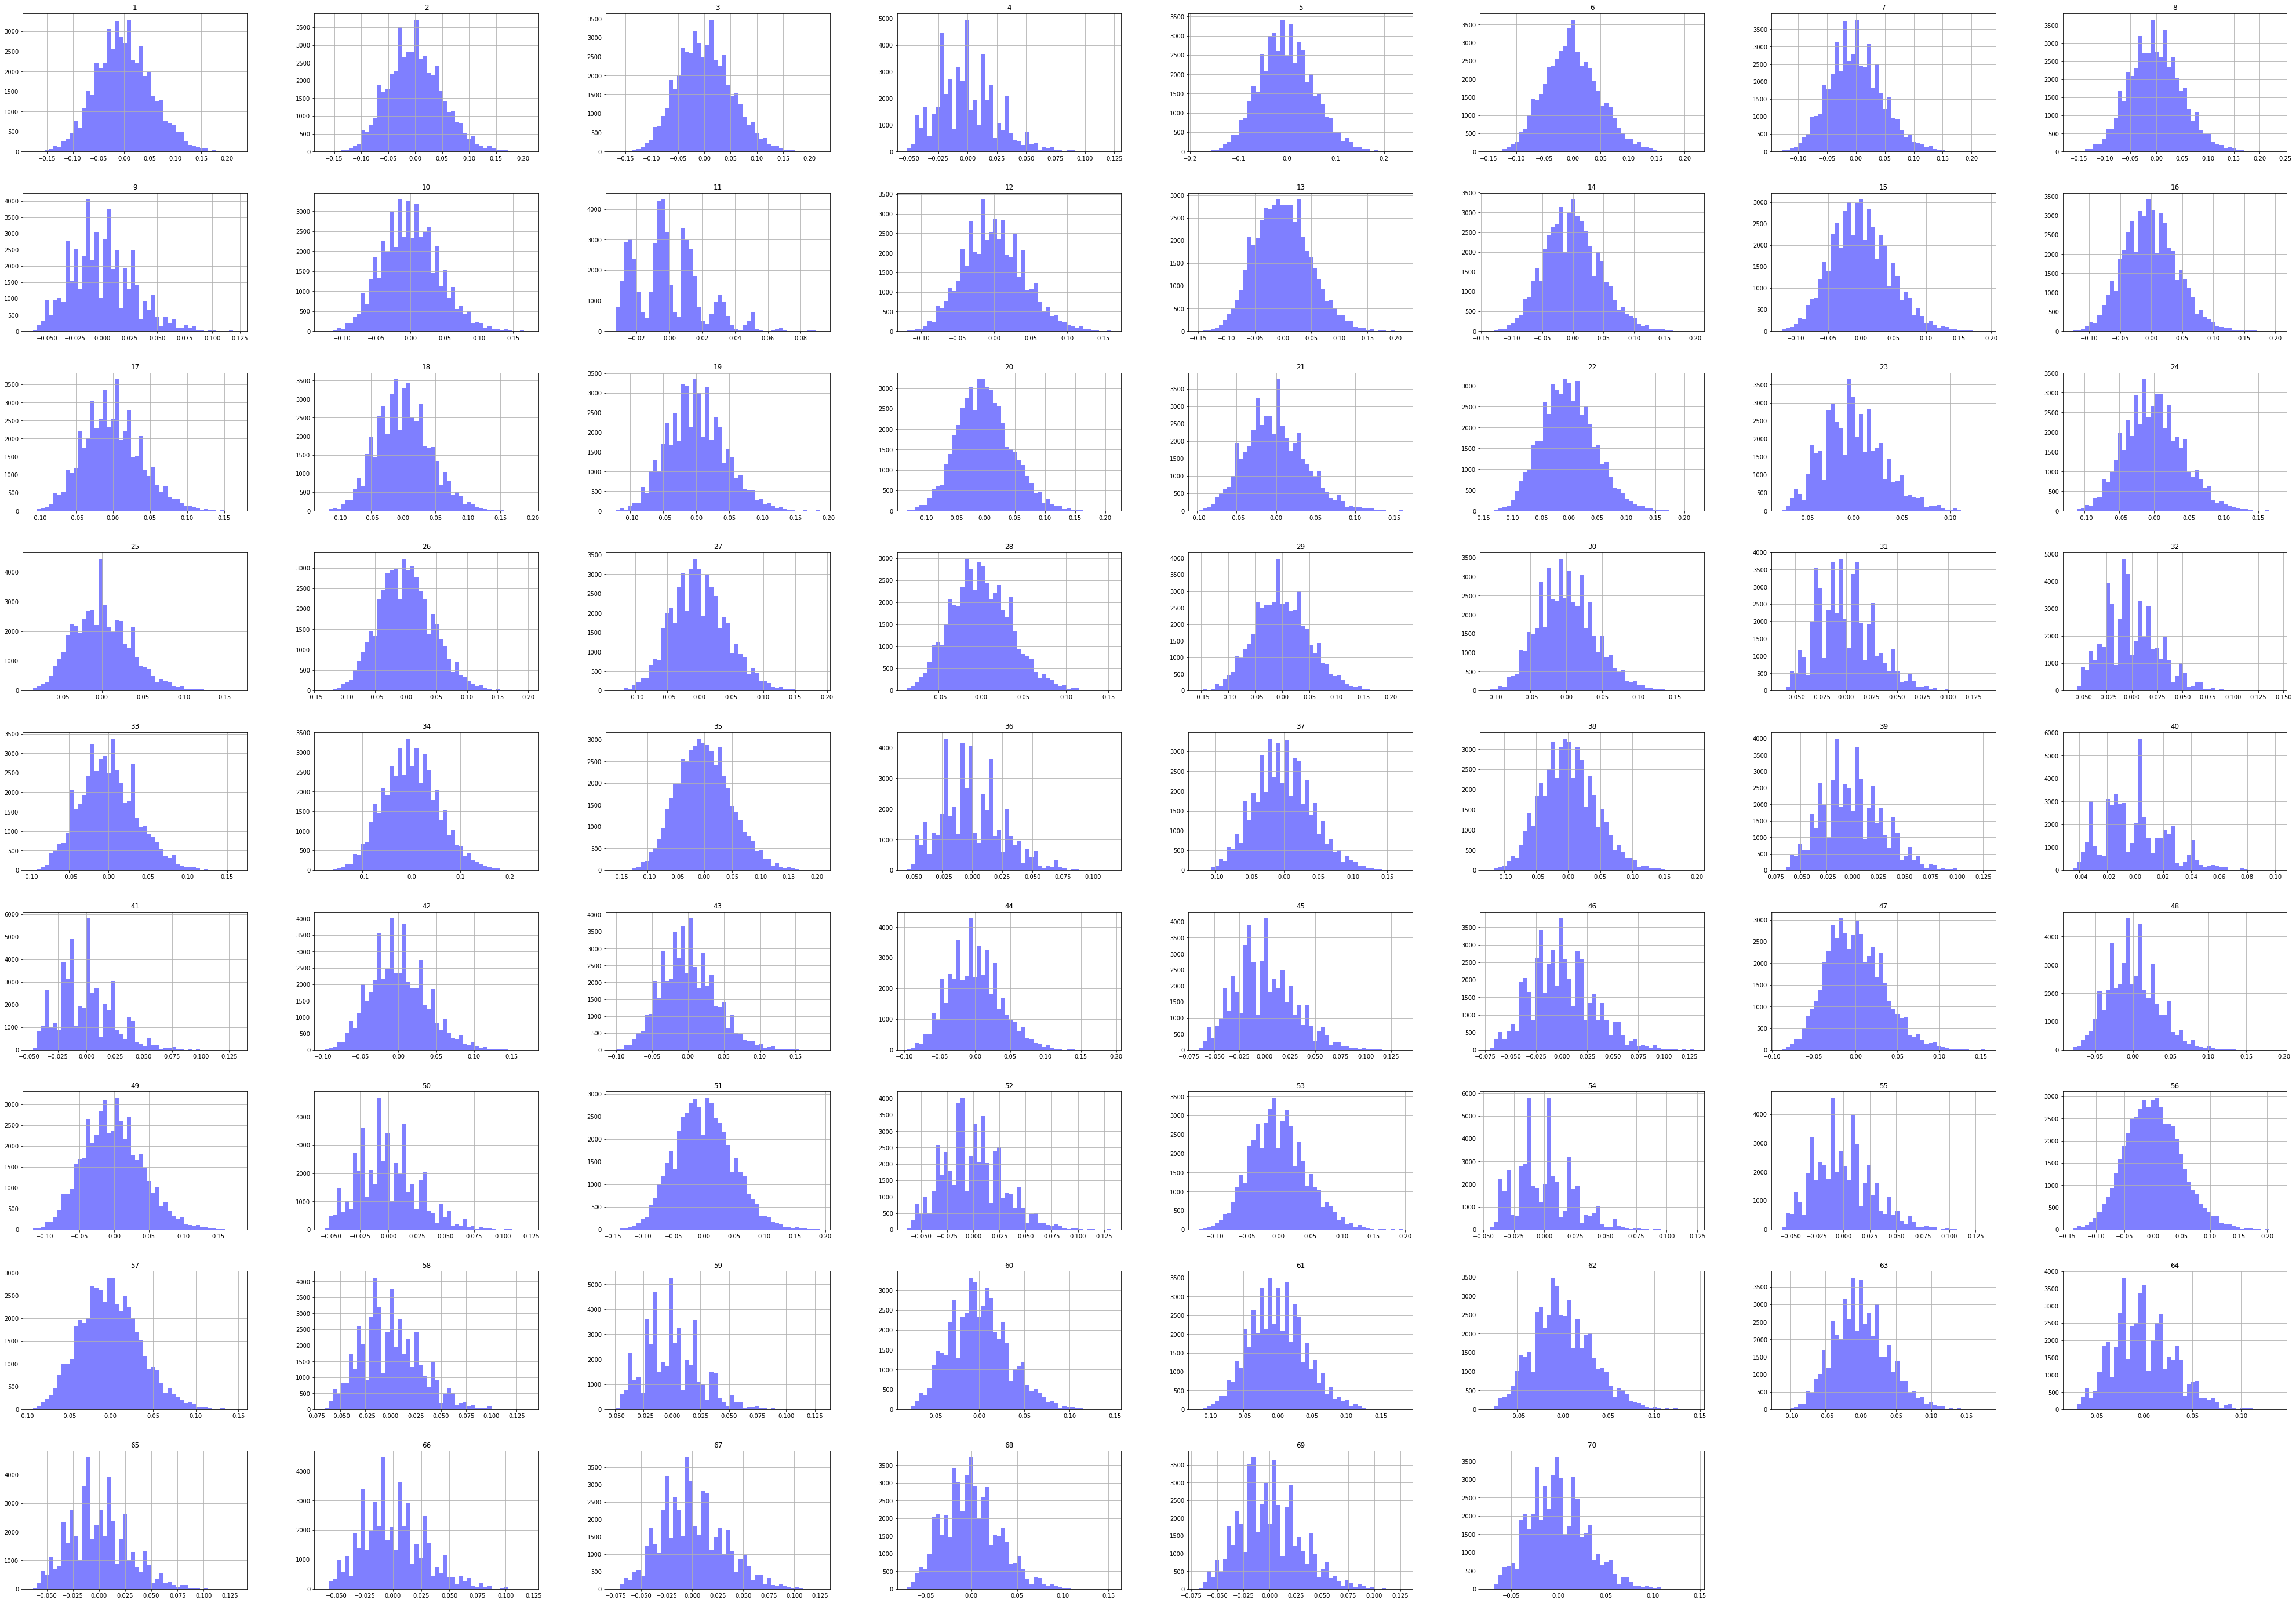

In [8]:
resampled_df.hist(alpha=0.5, color="blue", bins=50, figsize=(70, 50));

#### Now, we actually conduct the **permuation test**, where we classify neurons as either *selective* or *not-selective*

In [13]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87.auc_df, resampled_df, real_diff_vals, p_value=0.05, threshold=5)

#### After classifying the neurons as either selective, not-selective, or unclassified, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for `OpenArms_centerpoint`. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for `ClosedArms_centerpoint`.

In [14]:
epm_selective_neurons = Resampler.classify_by_behavior(drd87_classified_neurons, real_diff_vals, "OpenArms_centerpoint", "ClosedArms_centerpoint")
plot_pie_chart(epm_selective_neurons, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

In [16]:
for neuron in epm_selective_neurons:
    if epm_selective_neurons[neuron] == "OpenArms_centerpoint":
        print("{}: open-selective".format(neuron))
    elif epm_selective_neurons[neuron] == "ClosedArms_centerpoint":
        print("{}: closed-selective".format(neuron))

1: open-selective
4: open-selective
5: open-selective
7: open-selective
8: closed-selective
10: closed-selective
13: closed-selective
14: closed-selective
15: open-selective
17: open-selective
19: open-selective
21: open-selective
22: closed-selective
23: open-selective
24: closed-selective
30: open-selective
31: open-selective
32: open-selective
33: open-selective
34: open-selective
35: open-selective
37: open-selective
38: open-selective
39: open-selective
40: open-selective
41: open-selective
42: open-selective
43: open-selective
47: open-selective
48: open-selective
49: open-selective
51: open-selective
52: open-selective
55: open-selective
58: open-selective
59: open-selective
60: open-selective
61: open-selective
70: open-selective
